In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [4]:
hour_df_mid_usd = pd.read_csv('../cleaned_data/hour_data_mid_usd.csv', index_col='time_utc')
hour_df_mid_usd.index = pd.to_datetime(hour_df_mid_usd.index).tz_localize('UTC').tz_convert('America/New_York').rename('time_est')
hour_df_usd_price = (1/hour_df_mid_usd).fillna(method='ffill')
hour_df_usd_returns = hour_df_usd_price.pct_change()

In [5]:
minute_df_mid_usd = pd.read_csv('../cleaned_data/minute_data_mid_usd.csv', index_col='time_utc')
minute_df_mid_usd.index = pd.to_datetime(minute_df_mid_usd.index).tz_localize('UTC').tz_convert('America/New_York').rename('time_est')
minute_df_usd_price = (1/minute_df_mid_usd).fillna(method='ffill')
minute_df_usd_returns = minute_df_usd_price.pct_change()

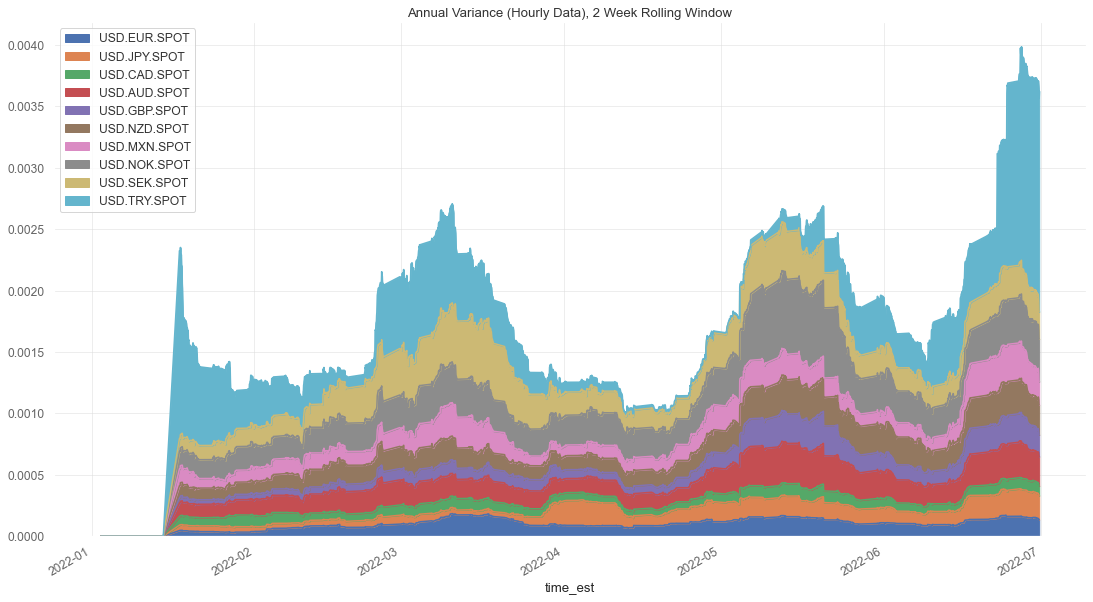

In [6]:
rolling_weekly_var = (hour_df_usd_returns.rolling(10*23).var()*(252*23)**(1/2))
rolling_weekly_var.plot.area(title='Annual Variance (Hourly Data), 2 Week Rolling Window')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

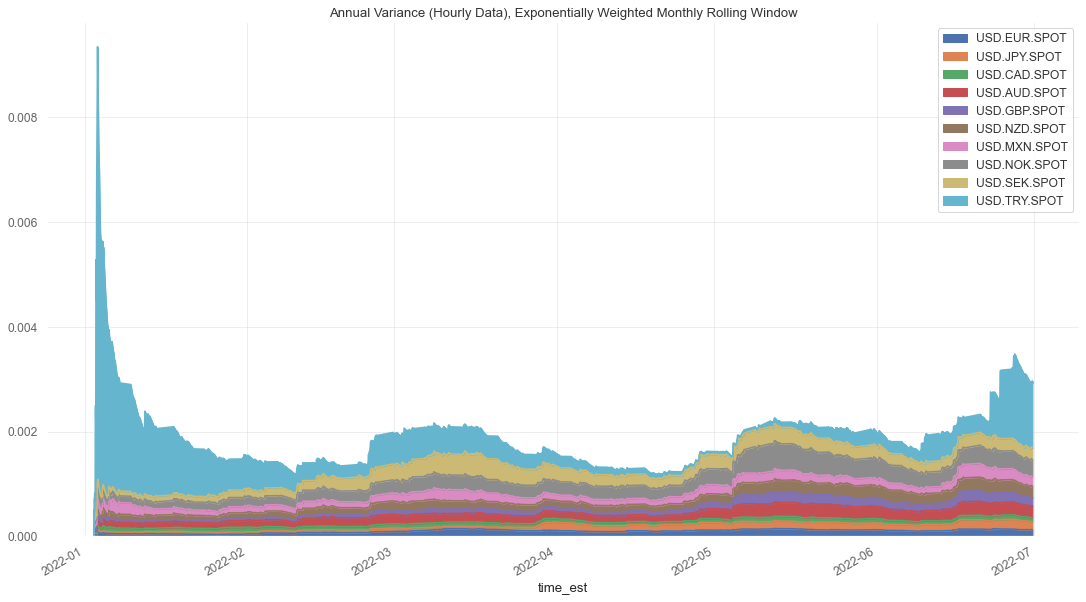

In [7]:
rolling_weekly_var = (hour_df_usd_returns.ewm(span=23*21).var()*(252*23)**(1/2))
rolling_weekly_var.plot.area(title='Annual Variance (Hourly Data), Exponentially Weighted Monthly Rolling Window')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

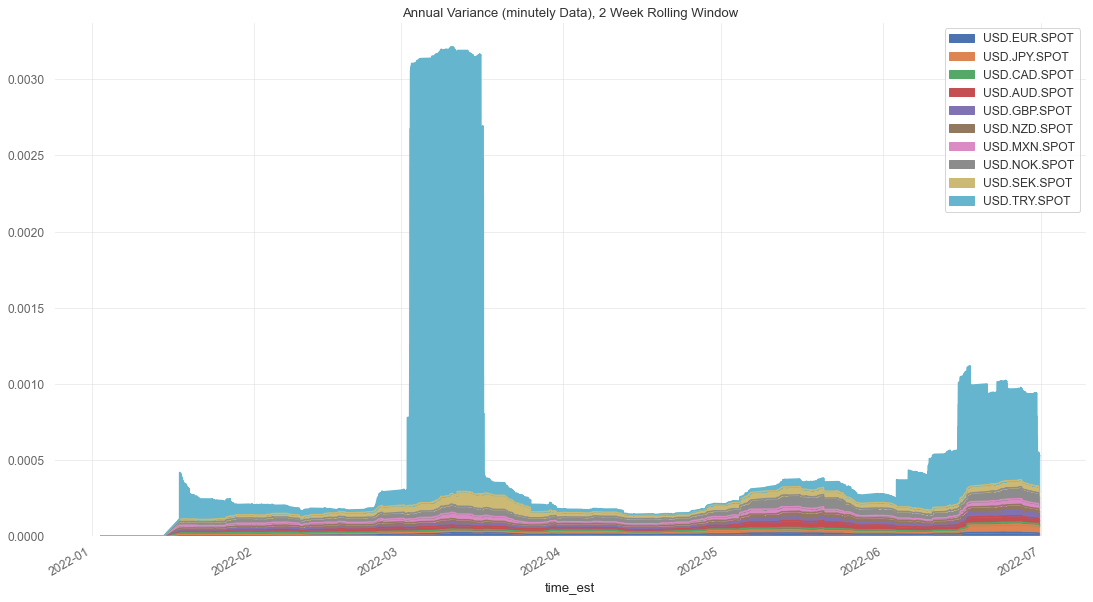

In [8]:
rolling_weekly_var_minute = (minute_df_usd_returns.rolling(10*23*60).var()*(252*23*60)**(1/2))
rolling_weekly_var_minute.plot.area(title='Annual Variance (minutely Data), 2 Week Rolling Window')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

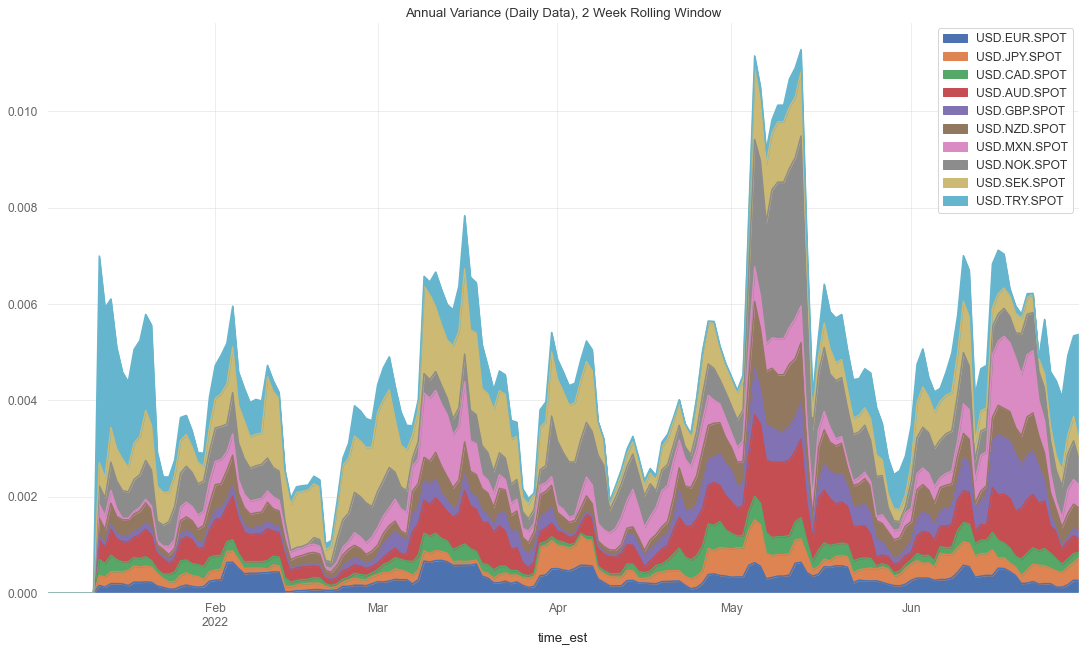

In [9]:
daily_df_usd_price = minute_df_usd_price.resample('1d').last()
daily_df_usd_returns = daily_df_usd_price.pct_change().dropna()
rolling_weekly_var_daily = (daily_df_usd_returns.rolling(10).var()*(252)**(1/2))
rolling_weekly_var_daily.plot.area(title='Annual Variance (Daily Data), 2 Week Rolling Window')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Diagonalized

#### Daily

In [27]:
def min_var_port(sigma):
    try:
        w = cp.Variable(len(sigma.columns))
    except:
        w = cp.Variable(sigma.shape[1])
    obj = cp.quad_form(w,sigma)
    constraints = [cp.sum(w)==1,w >= 0]
    prob= cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()
    try:
        weights = pd.DataFrame(w.value, index=sigma.index)
    except:
        weights = w.value
    return weights

In [29]:
rolling_weekly_var_daily = rolling_weekly_var_daily.dropna()
rolling_min_var_diag = []
for x in range(len(rolling_weekly_var_daily)):
    rolling_min_var_diag.append(min_var_port(np.diag(rolling_weekly_var_daily.iloc[x])))
rolling_min_var_diag_df = pd.DataFrame(rolling_min_var_diag, index= rolling_weekly_var_daily.index, columns = rolling_weekly_var_daily.columns)

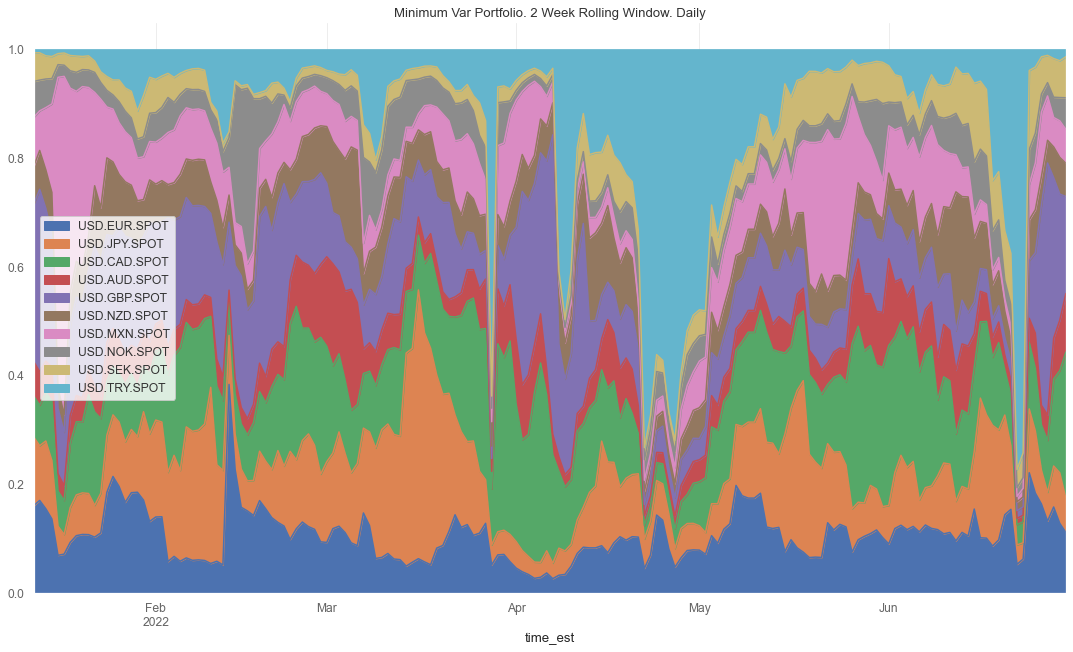

In [35]:
rolling_min_var_diag_df.plot.area(title='Minimum Var Portfolio. 2 Week Rolling Window. Daily')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#### No Lira

In [39]:
rolling_weekly_var_daily_nl = rolling_weekly_var_daily.drop(columns = 'USD.TRY.SPOT')
rolling_min_var_diag = []
for x in range(len(rolling_weekly_var_daily_nl)):
    rolling_min_var_diag.append(min_var_port(np.diag(rolling_weekly_var_daily_nl.iloc[x])))
rolling_min_var_diag_df_nl = pd.DataFrame(rolling_min_var_diag, index= rolling_weekly_var_daily.index, columns = rolling_weekly_var_daily_nl.columns)

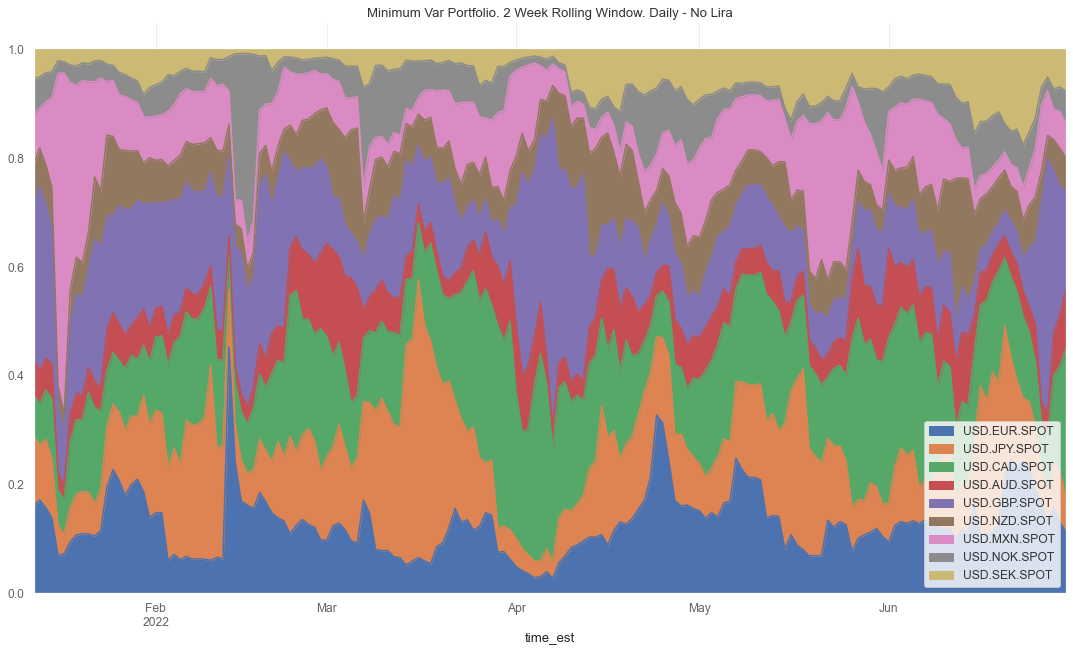

In [40]:
rolling_min_var_diag_df_nl.plot.area(title='Minimum Var Portfolio. 2 Week Rolling Window. Daily - No Lira')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

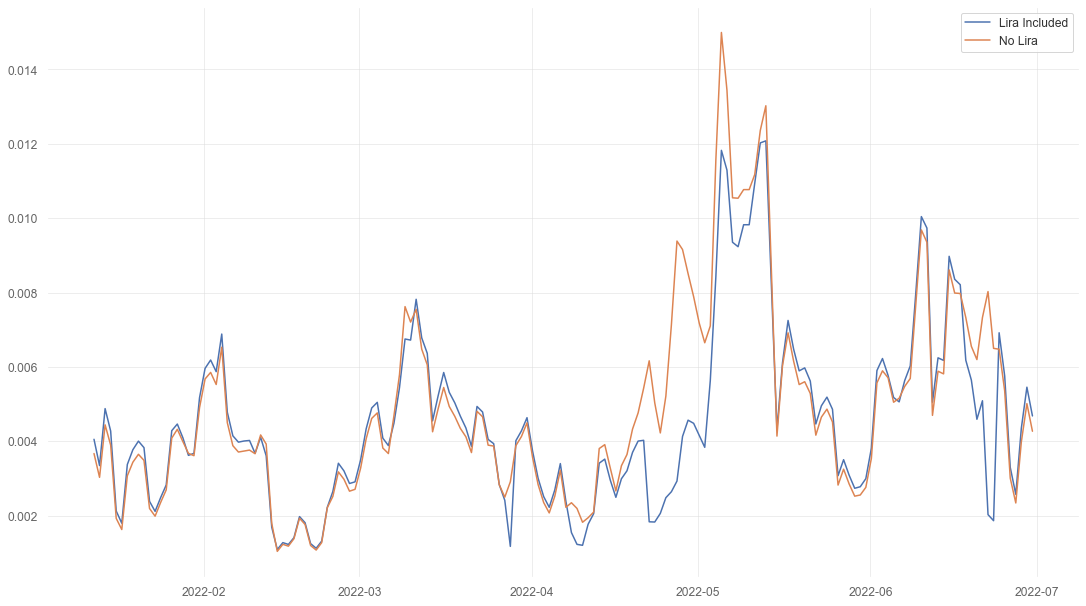

In [56]:
with_lira =(rolling_weekly_var_daily * rolling_min_var_diag_df).sum(axis=1)
with_outlira = (rolling_weekly_var_daily_nl * rolling_min_var_diag_df_nl).sum(axis=1)
plt.plot(with_lira*(252)**(1/2))
plt.plot(with_outlira*(252)**(1/2))
plt.legend(['Lira Included', 'No Lira'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#### Hourly Min Var

In [58]:
rolling_weekly_var = rolling_weekly_var.dropna()
rolling_weekly_var_hourly_nl = rolling_weekly_var.drop(columns = 'USD.TRY.SPOT')
rolling_min_var_diag = []
for x in range(len(rolling_weekly_var_hourly_nl)):
    rolling_min_var_diag.append(min_var_port(np.diag(rolling_weekly_var_hourly_nl.iloc[x])))
rolling_min_var_diag_df_nl = pd.DataFrame(rolling_min_var_diag, index= rolling_weekly_var_hourly_nl.index, columns = rolling_weekly_var_hourly_nl.columns)

In [59]:
rolling_min_var_diag_df_nl

,USD.EUR.SPOT,USD.JPY.SPOT,USD.CAD.SPOT,USD.AUD.SPOT,USD.GBP.SPOT,USD.NZD.SPOT,USD.MXN.SPOT,USD.NOK.SPOT,USD.SEK.SPOT
time_est,,,,,,,,,
2022-01-02 20:00:00-05:00,0.000194,0.000024,0.000061,0.000064,0.000936,-1.811634e-14,0.000103,0.998618,-1.811634e-14
2022-01-02 21:00:00-05:00,0.167153,0.063039,0.099800,0.150028,0.196249,2.750561e-02,0.167921,0.102192,2.611207e-02
2022-01-02 22:00:00-05:00,0.063932,0.076014,0.128400,0.184043,0.252261,3.519552e-02,0.196941,0.034063,2.915243e-02
2022-01-02 23:00:00-05:00,0.073954,0.084020,0.123468,0.131300,0.252351,4.054727e-02,0.223009,0.038641,3.271030e-02
2022-01-03 00:00:00-05:00,0.078454,0.092667,0.136940,0.145784,0.239386,4.489824e-02,0.184254,0.041299,3.631853e-02
...,...,...,...,...,...,...,...,...,...
2022-06-30 12:00:00-04:00,0.140198,0.115662,0.237903,0.080345,0.109755,8.172636e-02,0.099438,0.054838,8.013502e-02
2022-06-30 13:00:00-04:00,0.140243,0.115709,0.237662,0.080378,0.109802,8.174727e-02,0.099432,0.054860,8.016805e-02
2022-06-30 14:00:00-04:00,0.140533,0.115803,0.237979,0.080521,0.109983,8.191355e-02,0.098125,0.054923,8.022062e-02


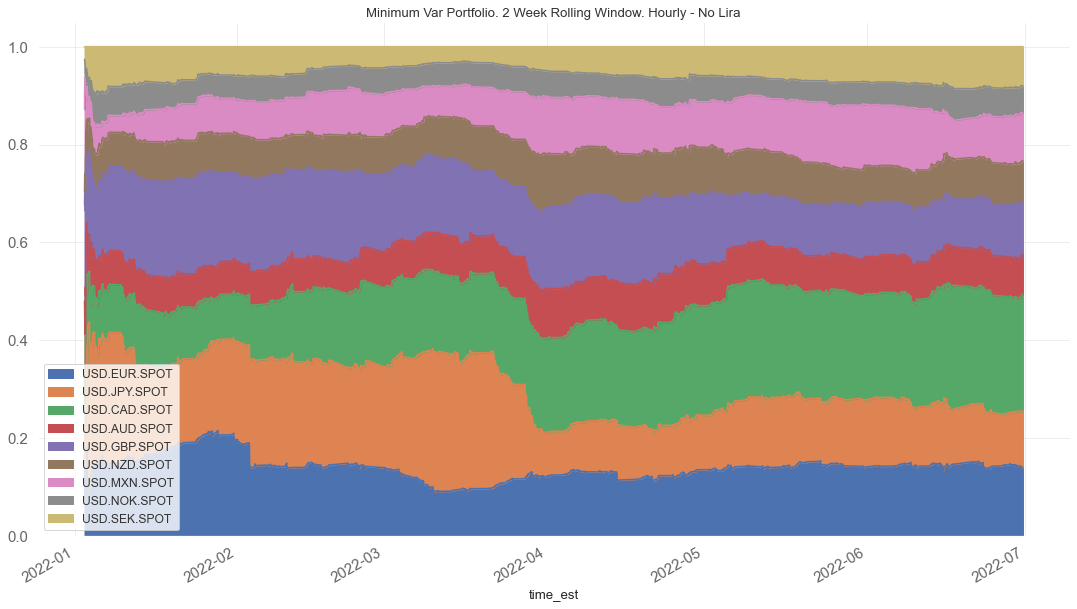

In [61]:
rolling_min_var_diag_df_nl.iloc[1:].plot.area(title='Minimum Var Portfolio. 2 Week Rolling Window. Hourly - No Lira', fontsize = 15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [62]:
rolling_weekly_var_hourly = rolling_weekly_var.dropna()
rolling_min_var_diag = []
for x in range(len(rolling_weekly_var_hourly)):
    rolling_min_var_diag.append(min_var_port(np.diag(rolling_weekly_var_hourly.iloc[x])))
rolling_min_var_diag_df = pd.DataFrame(rolling_min_var_diag, index= rolling_weekly_var_hourly.index, columns = rolling_weekly_var_hourly.columns)

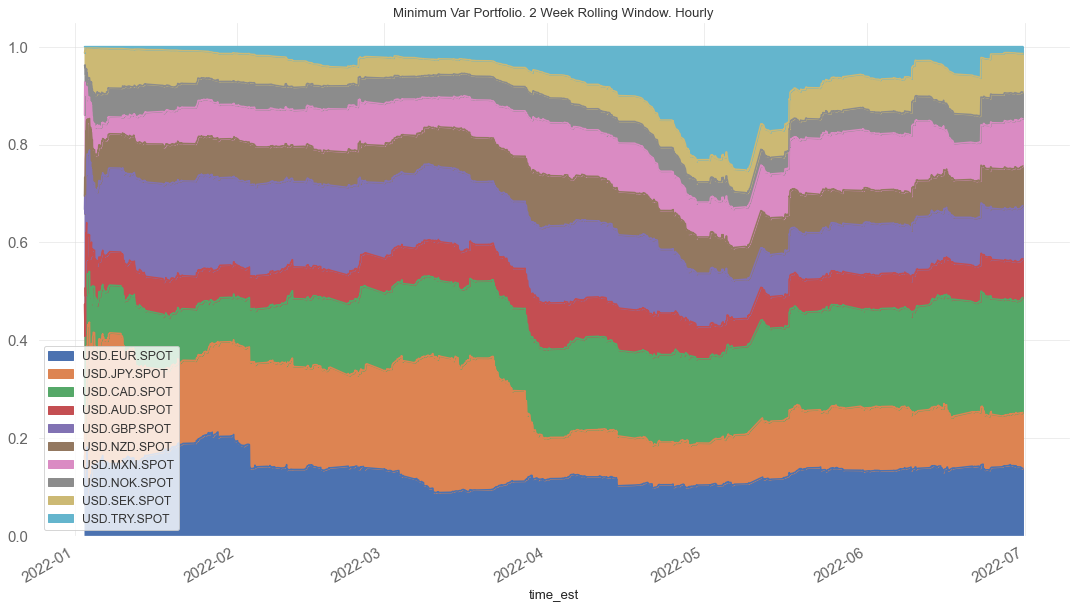

In [67]:
rolling_min_var_diag_df.iloc[1:].plot.area(title='Minimum Var Portfolio. 2 Week Rolling Window. Hourly', fontsize = 15)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

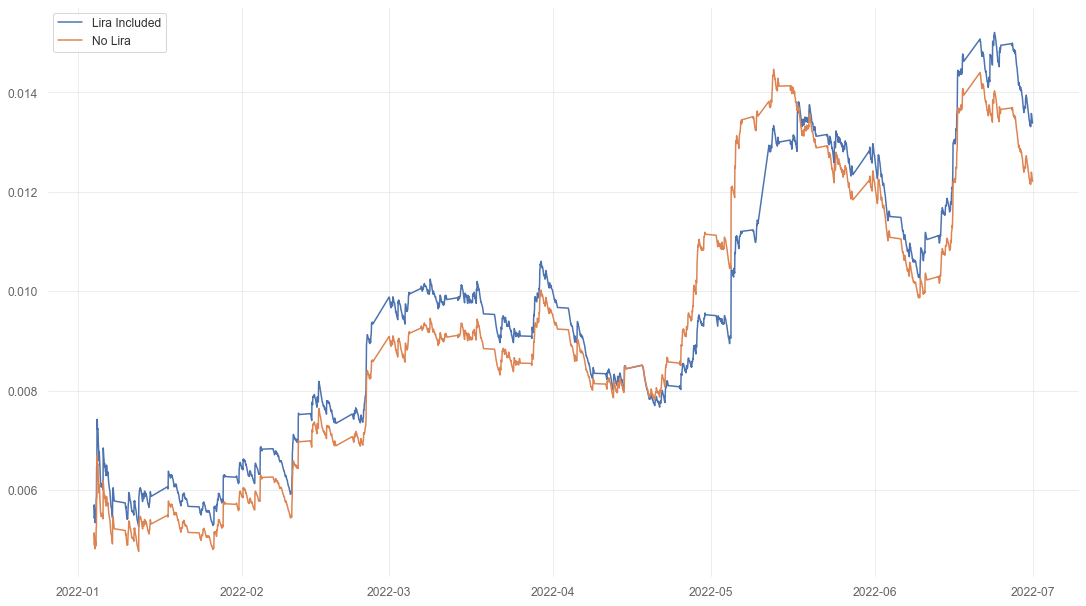

In [70]:
with_lira =(rolling_weekly_var_hourly.iloc[23:] * rolling_min_var_diag_df.iloc[23:]).sum(axis=1)
with_outlira = (rolling_weekly_var.iloc[23:] * rolling_min_var_diag_df_nl.iloc[23:]).sum(axis=1)
plt.plot(with_lira*(252*23)**(1/2))
plt.plot(with_outlira*(252*23)**(1/2))
plt.legend(['Lira Included', 'No Lira'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)